# Working with Outliers
## By: Karim Zakir

### Introduction
Datasets can often have outliers, points which are incredibly far or unlike most of the data. There are several reasons such points can appear in the dataset. Those points could represent anomalies, unusual observations, or just data-entries. Either way, they can greatly affect the accuracy of a machine learning model or any statistical analaysis in general. As such, during data preprocessing, one of the objectives is to detect and remove all of the outliers in the dataset as possible. This can prove challenging, since every dataset has different data distributions, and outliers can often be overlooked when going through the data; thus, it is essential to know a variety of outlier detection techniques. In this notebook, we will focus on four techniques: numeric outlier technique, Cook's Distance, Mahalanobis Distance, and Density-Based Spatial Clustering of Applications with Noise (DBSCAN). These four method are quite different from each other (technically wise), and should provide us with a good toolset to detect outliers in the future. Note that all of these methods are non-parametric methods of outlier detection, since I won't make any assumptions about the distribution of the data.

For this notebook, I will use the [Brazilian Houses To Rent](https://www.kaggle.com/dataset/0fc2c2957155f98e380a0e5e7db219aff29962b37b13e6ac5a569389cfe26e83/version/1) dataset obtained from Kaggle. This dataset is perfect for this notebook, since it contains data-entry errors, while also containing data which can throw off the techniques, as we will see later in the notebook. 

In order to understand how effective each of the methods are, we will take a closer look at the observations that were identified as outliers. 

In order to understand how effective each of the methods are, we will compare the accuracy of the model trained using filtered datasets to the accuracy of the model trained using the entire dataset with unfiltered outliers. The model we are going to use will be an ordinary least squares Linear Regression model from scikit-learn, since it is incredibly sensetive to outliers. Our accuracy metric is going to be mean absolute error, since it is quite appropriate for our model and dataset choices. Additionally, we will take a closer look at the observations which the methods will identify as outliers, since they will provide us with an insight into how the techniques work and allow us to asses the accuracy of the detection techniques further. 

Throughout this notebook, I will make certain decisions, which are not directly related to outlier detection techniques, such as feature choice. These decision are not going to be explained within this notebook; however, they are explained in the "Working with Outliers Extras" notebook.

Let's start by importing all of the necessary libraries and taking a quick look at the dataset!

**Make sure to mention that you will be removing the observations right away and then taking a closer look at them**
**Or you could also just change your method work and stuff, maybe all of this modelling stuff is quite useless**
**You'll be able to show off these skills in the late notebooks, maybe focus on just outliers now**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.cluster import DBSCAN
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
houses = pd.read_csv("houses_to_rent_v2.csv")
houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


## Initial Model
Our first objective during this investigation is to train a model with the unfiltered dataset and measure its accuracy using mean absolute error. This score will be our baseline score, to which we will compare our future accuracy measurements from models trained with filtered data. Additionally, when preparing the data, we will use the same imputation methods throughout the whole investigation to reduce any confounding variables.

In order to stay consistent when measuring accuracy, we will first split the data into training and test data, and only modify/work on traning data, while test data will be exclu
sively used for testing. This allows us to test the model without potential overfitting and also allows us to minimize any confounding variables during testing.

For the features, we will use the following columns: city, area, rooms, bathroom, parking spaces, floor, animal, and furniture. Our target is going to be total (R$). We will not be using other columns, since they are unlikely to be available when applying the data on new apartments/houses.

In [3]:
# Defining the features/target and splitting the data
features = ["city", "area", "rooms", "bathroom", "parking spaces", "floor", "animal", "furniture"]
target = ["total (R$)"]
X = houses[features]
y = houses[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [4]:
# Preparing categorical data with One Hot Encoding
cat_cols = ["city", "animal", "furniture"]
city_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

oh_city_train = pd.DataFrame(city_encoder.fit_transform(X_train[cat_cols]))
oh_city_test = pd.DataFrame(city_encoder.transform(X_test[cat_cols]))

oh_city_train.index = X_train.index
oh_city_test.index = X_test.index

X_train.drop(cat_cols, axis=1, inplace=True)
X_test.drop(cat_cols, axis=1, inplace=True)

X_train = X_train.merge(oh_city_train, left_index=True, right_index=True)
X_test = X_test.merge(oh_city_test, left_index=True, right_index=True)

In [5]:
# Floor has some non-numerical values ('-'), these will be replaced by 0, since I am assuming there are no floors, and the data is not missing
X_train.replace({"-": 0}, inplace=True)
X_test.replace({"-": 0}, inplace=True)
X_train["floor"] = X_train["floor"].astype(int)
X_test["floor"] = X_test["floor"].astype(int)
# Apart from this, there is no other potentially missing data in the dataset

In [6]:
default_model = LinearRegression()
default_model.fit(X_train, y_train)
default_predictions = default_model.predict(X_test)
baseline_mae = mean_absolute_error(default_predictions, y_test)
baseline_mae

2677.2151506422433

In [7]:
houses[target].mean()

total (R$)    5490.487
dtype: float64

2677.215... will be our baseline score, which we will use to compare our other models. This is a definitely suboptimal score, considering that the average of our target is 5490.487; however, the objective currently is not to create an accurate model. The objective is to improve our model by identifying and removing outliers. So, let's dive into some of the outlier detection techniques!

## Numeric Outlier Technique
The Numeric Outlier Technique will arguably be the simplest method within this notebook. For this non-parametric method, we need to calculate the first and third quartiles, as well as the interquartile range. We then calculate the upper and lower 'bounds'. The upper bound is calculated by adding the interquartile range multipled typically by 1.5 to the third quartile. Similarly, the lower bound is calculated by subtracting the interquartile range multipled by 1.5 from the first quartile. Any point that lies below or above the lower bound and the upper bound respectively is considered an outlier. By having the interquartile range multiplier equal to 1.5, the upper and lower bounds will correspond to the upper and lower whiskers in a boxplot. Here is the formula visualized:
<p align="center">
    <img src="https://www.kdnuggets.com/wp-content/uploads/ouotlier-detection-eq1.jpg" alt="Numeric Outlier Formula">
</p>

Since this method only works on a one dimensional space, we will apply this method to each feature and target individually.

To save time and processing power, we will only apply this method to a select number of columns, since it does not make sense to apply this method to the encoded columns where the values are only 0 and 1.

In [8]:
applicable_cols = ["area", "rooms", "bathroom", "floor", "total (R$)"]
k = 1.5
num_out_train = X_train.merge(y_train, left_index=True, right_index=True)
to_remove = {}
for col in applicable_cols:
    quantiles = num_out_train[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    lower_bound = q1 - k*iqr
    upper_bound = q3 + k*iqr
    records_to_remove = num_out_train[(num_out_train[col] > upper_bound) | (num_out_train[col] < lower_bound)].index
    to_remove[col] = set(records_to_remove)

In [9]:
combined = set()
for indexes in to_remove.values():
    combined.update(indexes)
print("Removed:", len(combined))
len(combined) / len(X_train) * 100

Removed: 1161


14.47811447811448

In [10]:
num_out_X_train = X_train.drop(list(combined), axis=0)
num_out_y_train = y_train.drop(list(combined), axis=0)
num_out_regress = LinearRegression()
num_out_regress.fit(num_out_X_train, num_out_y_train)
num_out_predictions = num_out_regress.predict(X_test)
num_out_mae = mean_absolute_error(num_out_predictions ,y_test)
num_out_mae

2356.5500035298232

In [11]:
baseline_mae - num_out_mae

320.6651471124201

Using the numeric outlier technique of outlier detection, we saw an increase in our model's performance. On average, it now estimates the value of the house better by approximately 320.67 R$. However, using this method, we have removed 1161 observations, which is about 14.5% of our training dataset. This is a sizable chunk of the training data, which could possibly mean that we have also removed valid records from the training data, since it is hard to consider almost 15% of the data to be outliers. Finally, it is worth tinkering around with the scaling factor, k, when using this technique to possibly find the most optimal value. Both of these inquiries will be looked into in more detail in the later section

### Numeric Outlier In Detail
We will begin the detailed analysis by looking closer at the records we have originally removed to see whether it would have been better to actually keep them or not

In [12]:
num_out_dropped = num_out_train.loc[list(combined)]
custom_groups = {}
for key, values in to_remove.items():
    removed_obsv = num_out_dropped.loc[values]
    custom_groups[key] = removed_obsv

In [13]:
summary_table = pd.DataFrame(["mean", "count", "min", "max", "std"], columns=["metric"])
summary_table.set_index("metric", inplace=True)
for key in custom_groups.keys():
    summary_table[key] = np.NaN

In [14]:
for key, group in custom_groups.items():
    summary_table.loc["mean", key] = group[key].mean()
    summary_table.loc["count", key] = group[key].count()
    summary_table.loc["min", key] = group[key].min()
    summary_table.loc["max", key] = group[key].max()
    summary_table.loc["std", key] = group[key].std()
summary_table

,area,rooms,bathroom,floor,total (R$)
metric,,,,,
mean,688.397260,5.501548,7.282051,23.855814,2.014214e+04
count,511.000000,323.000000,78.000000,215.000000,5.270000e+02
min,372.000000,5.000000,7.000000,19.000000,1.398000e+04
max,46335.000000,13.000000,10.000000,301.000000,1.120000e+06
std,2356.372676,0.950236,0.681813,19.384517,4.903646e+04


The statistical summary above provides us with a good picture of whether the outliers we have removed were valid entries or not. Based on the maximum for 'area' and 'floor', we have removed some entries, whcih were most likely invalid. However, the minimum and the mean results for each of the columns possibly suggests that a majority of the entries we have removed were possibly valid entries, which should have been considered as part of the training data. This is especially the case if we look at the 'rooms' column, where the average is quite low and shows a plausible amount of rooms for a house. Based on this, we can say that most of the outliers that we have removed using the numeric outlier method were likely high-class houses, which are just not as frequent in the Brazilian house market. This suggests that we should increase the upper bound by increasing our scaling factor to include the more expensive houses within our dataset.

Additionally, since the minimum values are quite high for each column, we know that the lower bound is fine and does not need to be focused on or modified.

### Numeric Outlier Conclusion

Numeric Outlier was an incredibly simple method for detecting outliers, where we only had to calculate the upper and lower quartiles to use this method. Definitely, one of its disadvantages was that we had to apply this method to each column individually, meaning that the feature columns and the target were not considered collectively. 

Using this method, we have removed a large chunk of the training dataset - approximately 15% of the training dataset. Using the statistical summary, we saw that while we have removed the 'true' outliers, which were most likely data errors, we have also removed a majority of proper data for upper-class housing, which could make our model incredibly ineffective for those kind of houses. In general, I think this was an ineffective method for this particular dataset, since we lost a big chunk of useful data, and our model is likely ineffective for an entire segment of the house market. Perhaps, this method could be more useful if the data was more evenly spread out, meaning that there were just as many high-class houses as there were middle to lower-class houses in the dataset.

## Cook's Distance
Cook's Distance is a really appropriate method for outlier detection in this case, since we are using Linear Regression and are attempting to improve our model by getting rid of outliers.

To find Cook's distance, we will use the statsmodels library, which can automatically find Cook's distance.

In [15]:
# Check that this is actually how you're supposed to do it
sm_model = sm.OLS(y_train, X_train).fit()
influence = sm_model.get_influence()
cooks = influence.cooks_distance[0]
cooks_df = pd.DataFrame(cooks, columns=["cooks"])
cooks_df.index = X_train.index
X_train_cooks = X_train.merge(cooks_df, left_index=True, right_index=True)

In [16]:
cooks_threshold = 4/len(X_train_cooks)
X_train_cooks_filtered = X_train_cooks[X_train_cooks["cooks"] < cooks_threshold]
y_train_cooks_filtered = y_train.loc[X_train_cooks_filtered.index]

In [17]:
# Saving the removed observations for later analysis
cooks_removed_X = X_train_cooks[X_train_cooks["cooks"] >= cooks_threshold]
cooks_removed_y = y_train.loc[cooks_removed_X.index]

In [18]:
X_train_cooks_filtered.drop(["cooks"], axis=1, inplace=True)

In [19]:
cooks_model = LinearRegression()
cooks_model.fit(X_train_cooks_filtered, y_train_cooks_filtered)
cooks_predictions = cooks_model.predict(X_test)
cooks_mae = mean_absolute_error(cooks_predictions, y_test)
cooks_mae

2514.7279991582222

In [20]:
baseline_mae - cooks_mae

162.48715148402107

In [21]:
len(X_train_cooks) - len(X_train_cooks_filtered)

8

By removing just 8 observations from the training dataset using Cook's distance, we have improved the accuracy of our model by ~162.49, which is a decent increase in the performance. This result shows how sensetive linear regression is to outliers, since we only removed 8 observations. We should look at those observations in more detail...

### Cook's Distance in More Detail

In [22]:
cooks_removed_X.merge(cooks_removed_y, left_index=True, right_index=True)

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,cooks,total (R$)
6230,340,5,4,2,7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.023421,233200
6947,486,8,4,6,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000656,27580
5915,24606,5,4,4,12,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.003419,18320
2182,700,4,7,8,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.001899,54430
1444,42,1,1,0,10,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000620,32750
2562,80,3,2,2,301,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.135276,3549
2397,46335,4,8,5,11,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.006456,10220
255,155,1,4,0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.100990,1120000


As we can see, some of these records are clearly entry errors, such as records 2562 or 2397. Additionally, using the method, we have also removed  records such as 1444 or 6947, where there is nothing outright wrong with them at first. However, since Cook's Distance considers the data collectively, we managed to spot the records where the target was too high for housing with those features. Those could be 'true' observations; however, as shown by Cook's Distance, they are incredibly unlikely and are most likely errors in data entry. This is especially useful, since I do not have much knowledge about the Brazilian house market nor are these entries immediately recognizable in a large dataset.

### Cook's Distance Conclusion

Although we have not seen such an increase in performance by using Cook's Distance when compared to numeric outliers, we can be confident that the records we have removed were most-likely data entry errors. 

Using this dataset, we saw that Cook's Distance can be quite powerful and effective. It is especially useful if you are not knowledgable about the data or its context. The disadvantage of this method is that it is more mathematically difficult than numeric outliers method for instance. It also requires you to import the statsmodel library, but this, in my opinion, is not a significant drawback. Some might argue that since we have not seen such a large increase in the performance, this method is not that effective; however, we have only removed 8 outliers, but have still seen a relatively significant increase in the model. Furthermore, the dataset contains housing from different segments, which handicaps linear regression quite a bit, so the lack of strong performance is not necessarily the fault of Cook's Distance.

## Mahalanobis Distance
Mahalanobis Distance is another useful method for detecting outliers in multivariate data. 

In [23]:
mahalanobis_train = X_train.merge(y_train, left_index=True, right_index=True)
inv_covmat = np.linalg.pinv(mahalanobis_train.cov())
# I have used pseudo-inverse, since the np library throws a Singular Matrix error when using the standard inverse
mean = np.mean(mahalanobis_train)
mahalanobis_train["mahalanobis_distance"] = np.NaN

In [24]:
for index, values in mahalanobis_train.iterrows():
    values = values[0:15]
    mahalanobis_train.loc[index, "mahalanobis_distance"] = mahalanobis(values, mean, inv_covmat)

In [25]:
mahalanobis_threshold = chi2.ppf(0.95, mahalanobis_train.shape[1] - 1)
mahalanobis_filtered = mahalanobis_train[mahalanobis_train["mahalanobis_distance"] < mahalanobis_threshold]
mahalanobis_removed = mahalanobis_train[mahalanobis_train["mahalanobis_distance"] >= mahalanobis_threshold]

In [26]:
mahalanobis_X_test = mahalanobis_filtered.iloc[:,0:14]
mahalanobis_y_test = mahalanobis_filtered.iloc[:, 14]
mahalanobis_model = LinearRegression()
mahalanobis_model.fit(mahalanobis_X_test, mahalanobis_y_test)
mahalanobis_predictions = mahalanobis_model.predict(X_test)
mahalanobis_mae = mean_absolute_error(mahalanobis_predictions, y_test)
mahalanobis_mae

2523.9343585030283

In [27]:
baseline_mae - mahalanobis_mae

153.280792139215

In [28]:
mahalanobis_mae - cooks_mae

9.20635934480606

In [29]:
len(mahalanobis_removed)

4

This time, we have only removed 4 records; however, we still saw a substantial increase in the performance of the model. Indeed, the Cook's Distance method performed better only by ~9.21 R$ on average, despite removing 4 more records. This could suggest two things:
- the records that we have just removed contributed to the performance significantly more than the records we haven't removed
- we have removed different observations from the dataset

We are going to investigate this in the next section

### Mahalanobis's Distance In Detail

In [30]:
mahalanobis_removed

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,total (R$),mahalanobis_distance
5915,24606,5,4,4,12,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,18320,40.483562
2562,80,3,2,2,301,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3549,47.864910
2397,46335,4,8,5,11,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10220,76.215416
255,155,1,4,0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1120000,85.500535


As we can see, Mahalanobis Distance removed half of the records that Cook's Distance has removed. These are the records, where data entry is quite clearly incorrect. We did not, however, remove the 4 records, which seemed fine, but were most likely incorrect or did not make sense collectively. Perhaps, if we expanded the margin those records would be included.

In [35]:
mahalanobis_threshold_80 = chi2.ppf(0.8, mahalanobis_train.shape[1] - 1)
mahalanobis_train_80_removed = mahalanobis_train[mahalanobis_train["mahalanobis_distance"] >= mahalanobis_threshold_80]
mahalanobis_train_80_removed

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,total (R$),mahalanobis_distance
5915,24606,5,4,4,12,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,18320,40.483562
2562,80,3,2,2,301,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3549,47.864910
9241,12732,3,2,0,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2417,21.333782
2397,46335,4,8,5,11,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10220,76.215416
255,155,1,4,0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1120000,85.500535


Interestingly, although we expanded the two-tailed margin by quite a bit, we have only obtained one additional observation with the index 9241. This observation was not spotted by Cook's Distance, although it is most likely an error in data-entry, since it has incredibly huge area. This puts Cook's Distance effectiveness into question, since it has not spotted this particular outlier. We should check whether it affects the performance of the model or not.

In [124]:
mahalanobis_train_80 = mahalanobis_train[mahalanobis_train["mahalanobis_distance"] < mahalanobis_threshold_80]
mahalanobis_X_test_80 = mahalanobis_train_80.iloc[:,0:14]
mahalanobis_y_test_80 = mahalanobis_train_80.iloc[:, 14]
mahalanobis_model_80 = LinearRegression()
mahalanobis_model_80.fit(mahalanobis_X_test_80, mahalanobis_y_test_80)
mahalanobis_predictions_80 = mahalanobis_model_80.predict(X_test)
mahalanobis_mae_80 = mean_absolute_error(mahalanobis_predictions_80, y_test)
mahalanobis_mae_80

2428.638517498439

As you can see, by filtering out the observation 1492, we have increased the performance of our model substantilly, despite removing only one record. Perhaps it is worth expanding the range in order to remove as many outliers as possible; however, this comes with a risk of removing valid data entries. Thus, the process will need to be monitored closely to ensure that no valid records are removed from the training dataset.

### Mahalanobis's Distance Conclusion
Despite being a similar method to Cook's Distance, Mahalanobis's Distance is capable of detecting different outliers, as we saw previously, when we expanded the range. Additionally, we saw that, even when the range was relatively limited, the method detected the most influential outliers, making it quite effective and efficient. However, I think it is still quite important to play around with this method to ensure that all of the outliers are removed. Additionally, Mahalanobis Distance could be used in combination with Cook's Distance, since, as we saw previosuly, they can spot different outliers, which have a strong impact on the model. Also, by finding the same outliers, we gain more confidence to remove them.

Finally, as stated in the previous section, it is worth playing around with this method when analyzing datasets by expanding the detection range. However, this can only work properly when you're able to check the validity of the observations yourself to ensure that no 'true' records are removed.

## DBSCAN (Density Based Spatial Clustering of Applications with Noise)

In [37]:
dbscan_train = X_train.merge(y_train, left_index=True, right_index=True)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(dbscan_train)

DBSCAN()

In [38]:
unique = []
outlier_count = 0
for value in dbscan.labels_:
    if value not in unique:
        unique.append(value)
    if value == -1:
        outlier_count += 1
outlier_count

7955

In [39]:
outlier_count / len(X_train) * 100

99.20189549819179

One of the main issues with using DBSCAN is having to be careful by setting your own parameters. As you can see, if we keep the epsilon at its default value, then we get 7955 outliers, which is over 99% of our training dataset. It is not immediately clear what the epsilon value should be, so we will run an experiment to attempt to determine the best epsilon value for this dataset. We will increment the epsilon value by 0.5, starting from 0.5, and measure the MAE for new training datasets to determine the most optimal epsilon value.

In [40]:
eps_list = [i for i in np.arange(0.5, 200.5, 1)]
mae_list = []
removed_list = []
for eps in eps_list:
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(dbscan_train)
    labels_df = pd.DataFrame(dbscan.labels_, columns=["labels"])
    labels_df.index = dbscan_train.index
    current_copy = dbscan_train.copy()
    current_copy = current_copy.merge(labels_df, right_index=True, left_index=True)
    removed = len(current_copy[current_copy["labels"] == -1])
    removed_list.append(removed)
    current_copy = current_copy[current_copy["labels"] >= 0]
    dbscan_X = current_copy.iloc[:, :14]
    dbscan_y = current_copy.iloc[:, 14]
    dbscan_regress = LinearRegression()
    dbscan_regress.fit(dbscan_X, dbscan_y)
    dbscan_predictions = dbscan_regress.predict(X_test)
    dbscan_mae = mean_absolute_error(dbscan_predictions, y_test)
    mae_list.append(dbscan_mae)    

<AxesSubplot:title={'center':'Amount of Observations Removed'}>

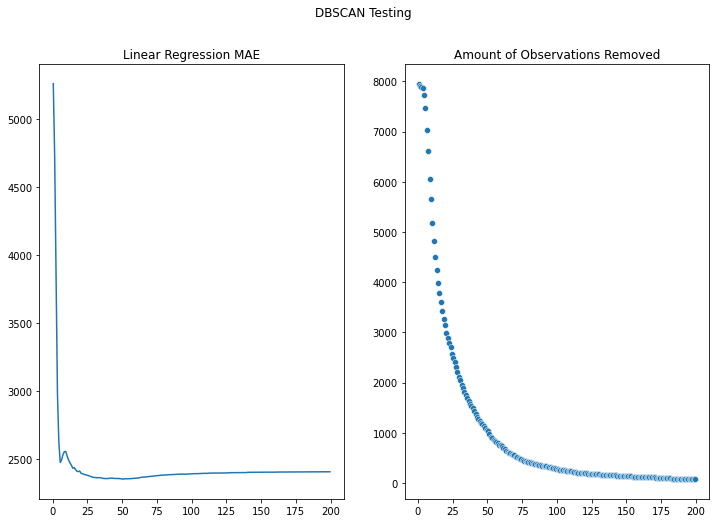

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
fig.suptitle("DBSCAN Testing")
ax[0].set_title("Linear Regression MAE")
ax[1].set_title("Amount of Observations Removed")
sns.lineplot(x=eps_list, y=mae_list, ax=ax[0])
sns.scatterplot(x=eps_list, y=removed_list, ax=ax[1])

As can be seen from the plots above, when we begin to increase the epsilon value, the model's MAE begins to decrease rapdily, until it levels off at around 50, and begins to increase after 60. The amount of observations that we remove also rapdily decreases and continues to do so as we increase our epsilon value. 

Interestingly, this method has removed the most observations from the record. At its lowest MAE, DBSCAN has deemed just less than 1000 observations as outliers, a lot more than what we got using Cook's Distance or Mahalanobis's Distance. This doesn't necessarily suggest that these observations were outliers. It is best to look into these observations in more detail in order to understand why the algorithm classified them as outliers.

### DBSCAN In More Detail

In [44]:
eps = 50.5
dbscan_50 = DBSCAN(eps=eps)
dbscan_50.fit(dbscan_train)
labels_df_50 = pd.DataFrame(dbscan_50.labels_, columns=["labels"])
labels_df_50.index = dbscan_train.index
outliers_index = labels_df_50[labels_df_50["labels"] == -1].index
outliers_dbscan = dbscan_train.loc[outliers_index]
len(outliers_dbscan)

1027

Due to the large amount of observations removed, we will instead look at the summary statistics for these observations, as well as a few samples from the removed data 

In [45]:
outliers_dbscan.describe()

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,total (R$)
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1.027000e+03
mean,459.561831,3.766310,4.145083,3.579357,5.388510,0.133398,0.047712,0.043817,0.081792,0.693281,0.843233,0.156767,0.327167,0.672833,1.439482e+04
std,1677.794661,1.173918,1.529879,1.951728,11.316809,0.340170,0.213260,0.204787,0.274181,0.461356,0.363758,0.363758,0.469407,0.469407,3.565462e+04
min,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000e+02
25%,254.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.532500e+03
50%,350.000000,4.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.327000e+04
75%,470.000000,4.000000,5.000000,5.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.676000e+04
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.120000e+06


As evident by the maximum values, DBSCAN spotted the outliers that (most-likely) contain data error entries. However, it has also removed some records that we have never seen before, such as the observation with the value 30 in its area column. Let's consider this observation in more detail.

In [46]:
outliers_dbscan[outliers_dbscan["area"] == 30]

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,total (R$)
7448,30,4,4,2,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,9323


To be honest, it is not immediately clear whether this record is an outlier or not. It was probably removed, due to its unusually low area, considering the price and the amount of rooms in this particular house. However, it is hard to be sure whether this is a data-error entry or a 'true' record. Either way, it could be considered an outlier, since this is a highly unusual record. Let's now consider a couple of other samples from the data

In [47]:
outliers_dbscan.sample(15)

,area,rooms,bathroom,parking spaces,floor,0,1,2,3,4,5,6,7,8,total (R$)
595,900,3,5,8,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,10370
653,280,3,2,2,10,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,12370
428,350,4,5,5,17,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,19990
9368,800,5,7,6,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,17280
9457,292,4,3,3,8,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,15030
3564,220,4,3,4,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,15340
8858,800,4,7,8,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,18840
6727,360,4,5,5,20,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,16690
10690,120,2,2,2,8,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,14020
2493,300,5,3,6,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5620


As we can see above, we cannot immediately tell from these observations whether they are errors in data-entry, or whether they are accurate observations. Indeed, we cannot be confident whether they can be considered to be 'unusual' observations, as these make up approximately 12.5% of the training data. Perhaps, we need to increase the epsilon, and perhaps decrease the min_samples parameter to ensure we only get the most unusual points.

**Increase the epsilon, reduce the min_samples**

### Conclusion